In [59]:
import numpy as np
from numpy.random import permutation
import pandas as pd
import sklearn as sklearn
import matplotlib.pyplot as plt
import collections                  # 词频统计库
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

import jieba
import jieba.posseg as pseg
import scipy
from datetime import datetime, date, timedelta
import pickle

import sys
import os

import warnings
warnings.filterwarnings('ignore')

import pdb
import re
import pika
import json

%matplotlib inline

pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', lambda x: '%.6f' % x)

plt.rcParams['font.sans-serif']=['SimHei']
plt.rcParams['axes.unicode_minus']=False

In [60]:
# 读取待分析的文件
words_file = './data/礼物长尾词_1606095511.csv'
df = pd.read_csv(words_file)
words_df = df[(df['关键词'].str.len() > 5) & (df['关键词'].str.len() < 20)][['关键词','长尾词数量']]
words_df.columns = ['words','lenword_count'] 
words_df.head()

,words,lenword_count
0,七号房的礼物,6501.000000
4,男人内心想收到的礼物,74.000000
7,十大女生喜欢的礼物,54.000000
8,男生最渴望收到的礼物,93.000000
9,送女朋友礼物排行榜,517.000000


In [61]:
print(len(words_df))

462369


#### 数据清洗：
1. 构建自定义停用词库

In [62]:
# 去掉word中的特殊字符
def remove_col_str(df,col):

    df[col].replace('\n\u4e00-\u9fa5\u0030-\u0039\u0041-\u005a\u0061-\u007a', '', regex=True, inplace=True)
    df[col].replace(' &#.*' , '', regex=True, inplace=True)
    df[col].replace('《|》| |~|，|？|。|（|）|、', '', regex=True, inplace=True)


remove_col_str(words_df,'words')

# 去重
words_df = words_df.sort_values(by='lenword_count',ascending=False).drop_duplicates(['words'],keep='first')
print(len(words_df))

457205


In [63]:
# 停用词
# 创建停用词列表
def get_stopwords_list(file_name):
    stopwords = [line.strip() for line in open(file_name,encoding='UTF-8').readlines()]
    return stopwords

# 对句子进行中文分词
def seg_depart(sentence,stopwords_list, flag_dict, word_split, words_all):
    # 对文档中的每一行进行中文分词
#     sentence_depart = jieba.lcut(sentence.strip())

    # 分词并给出词性
    # 根据词性对所有的词进行分组
#     sentence_depart = pseg.lcut(sentence.strip())
    sentence_depart = jieba.cut(sentence.strip())
    single_word_split = []
    out_list = []
    for word in sentence_depart:
        if word not in stopwords_list:
#             if flag in ['a','ag','ad','an','g','k','c','mq']:
#                 #不保留词性为形容词等词的词的词
#                 # 并将其加入到停用词库中
# #                 with open('stopwords_myself1.txt','a', encoding='UTF-8') as f:
# #                     f.write('\n' + word)
#                 continue
#             elif flag not in flag_dict:
#                 flag_dict[flag] = []
#                 flag_dict[flag].append(word)
                
#             elif word not in flag_dict[flag]:
#                 flag_dict[flag].append(word)
                
#             if word != '\t':
                out_list.append(word)
#                 single_word_split.append(word)
                word_split.append(word)
#     print(flag_dict)        
#     words_all.append(single_word_split)
    return ' '.join(out_list)



# 去除停用词
def move_stopwords(sentence_list, stopwords_list):
    # 去停用词
    out_list = []
    for word in sentence_list:
        if word not in stopwords_list:
            if not remove_digits(word):
                continue
            if word != '\t':
                out_list.append(word)
    return ' '.join(out_list)



#### 
2. 创建自定义词典

In [55]:
pattern = re.compile(r'(\d+岁|\d+年|\d+月|\d+日|\d+元|\d+块|\d+门|\d+升|\d+L|\d+l|\d+厘米|\d+米|\d+cm)')

#读取原有的自定义词典
my_dict = 'dict_my.txt'
original_words = []
with open (my_dict, 'r',encoding='utf-8') as f:
    for line in f.readlines():
        line = line.strip('\n')  #去掉列表中每一个元素的换行符
        original_words.append(line)

In [56]:
def get_my_words(words):
    tmp_words = []
    for index, row in words.iterrows():
        word_list = pattern.findall(row['words'])
        if len(word_list) > 0:
            for item in word_list: 
                if item not in original_words:
                    tmp_words.append(item)
                    
    with open (my_dict, 'a',encoding='utf-8') as f1:
        f1.write('\n'.join(tmp_words))


In [57]:
# 根据待分析数据 获取最全的自定词典库
get_my_words(words_df[['words']])

KeyboardInterrupt: 

In [65]:
# 分词并去停用词
# 读取自定义停用词
stopwords = get_stopwords_list('stopwords_myself.txt')

#设置自定义词库
jieba.load_userdict(my_dict)
flag_dict = {}
word_split = []
words_all = []
words_df['word_split'] = words_df['words'].apply(seg_depart, stopwords_list=stopwords,flag_dict=flag_dict,word_split=word_split,words_all=words_all)
# used_df['word_split'] = used_df['word_split'].apply(move_stopwords, stopwords_list=stopwords)


# print(flag_dict)
# flag_df = pd.DataFrame()

# for k, item in flag_dict.items():
#     print(En2Cn[k])
#     print(item)

words_df['words_count'] = 0
words_df.head(10)

,words,lenword_count,word_split,words_count
88288,礼物,4466347.000000,礼物,0
88287,礼物礼物,4466347.000000,礼物 礼物,0
88290,()的礼物,1354732.000000,礼物,0
88291,()()的礼物,1354698.000000,礼物,0
943,什么礼物什么,1133560.000000,礼物,0
948,生日礼物礼物,419978.000000,生日礼物 礼物,0
950,礼物生日礼物,414291.000000,礼物 生日礼物,0
88295,一()礼物,225414.000000,礼物,0
88296,<<买礼物>>,210250.000000,买 礼物,0
957,送什么礼物好,175615.000000,送 礼物,0


In [67]:
# 词频统计
word_counts = collections.Counter(word_split)       # 对分词做词频统计
# word_counts_top = word_counts.most_common(number)    # 获取前number个最高频的词
# print(word_counts)
word_counts_df = pd.DataFrame.from_dict(word_counts,orient ='index').reset_index()
word_counts_df = word_counts_df.rename(columns={'index':'word', 0:'word_freq'})
print(word_counts_df)

       word  word_freq
0        礼物     378456
1      生日礼物      42931
2         买      20362
3         送     116254
4        生日       9238
...     ...        ...
51117  3100          1
51118    凉凉          1
51119    天晒          1
51120  神话故事          1
51121    渡边          1

[51122 rows x 2 columns]


In [74]:
used_df = word_counts_df[( word_counts_df['word_freq'] / len(word_counts_df) > 0.02)]
# if len(my_df) > 20:
#     my_df20 = my_df[:int(len(my_df) * 0.2)]
used_df['value'] = 1
used_df

,word,word_freq,value
0,礼物,378456,1
1,生日礼物,42931,1
2,买,20362,1
3,送,116254,1
4,生日,9238,1
...,...,...,...
1001,店,1169,1
1161,句子,1310,1
1491,会,2226,1
1764,问,1304,1


In [77]:
used_df_s=pd.Series(1,used_df['word'])    
used_df_s

word
礼物      1
生日礼物    1
买       1
送       1
生日      1
       ..
店       1
句子      1
会       1
问       1
想       1
Length: 179, dtype: int64

In [79]:
# 原始数据去噪声 以高频词汇为基准 统计每个句子分词后出现高频词汇的次数 必须大于0
# all_words = words_df[['words_split']]
# for index, row in all_words.iterrows():
#     tmp = row['words_split'].split(" ")
#     row['found_count'] = 0
#     for t in tmp:
#         if t in my_df2['keyword']:
#             row['found_count'] += 1
import time

start = time.time()
# print(datetime.now().strftime("%Y/%m/%d, %H:%M:%S") + ",begin training")
all_words = words_df[['word_split']]
result_count = []
for index, row in all_words.iterrows():
    tmp = pd.Series(1,row['word_split'].split(" "))
    result = used_df_s + tmp
    if len(result.value_counts().values) > 0:
        result_count.append(result.value_counts().values[0])
    else:
        result_count.append(0)
    #print(result.value_counts().values)
#     tmp[]
    #print(result)
end = time.time()
print("耗时：")
print(end-start)

耗时：
1291.9982602596283


In [80]:
words_df['count'] = result_count
words_df

,words,lenword_count,word_split,words_count,count
88288,礼物,4466347.000000,礼物,0,1
88287,礼物礼物,4466347.000000,礼物 礼物,0,2
88290,()的礼物,1354732.000000,礼物,0,1
88291,()()的礼物,1354698.000000,礼物,0,1
943,什么礼物什么,1133560.000000,礼物,0,1
...,...,...,...,...,...
33371,送什么礼物比较好呢,nan,送 礼物,0,2
33372,书包衣服不必了,nan,书包 衣服 不必,0,0
33375,不知道老人都喜欢什么?送什么礼物?,nan,不 老人 都 喜欢 送 礼物,0,6
40981,我和女朋友认识一百天了,nan,女朋友 一百天,0,1


In [82]:

count_word = words_df[(words_df['count'] > 4) &  (words_df['lenword_count']>0)]
count_word

,words,lenword_count,word_split,words_count,count
88454,以礼物礼物作文600字,732.000000,礼物 礼物 作文 600 字,0,5
88455,让礼物作文600字作文,732.000000,礼物 作文 600 字 作文,0,5
643,情人节送男朋友送什么礼物,650.000000,情人节 送 男朋友 送 礼物,0,5
857,六一儿童节送孩子什么礼物,304.000000,六一 儿童节 送 孩子 礼物,0,5
807,母亲节送妈妈手工礼物,239.000000,母亲节 送 妈妈 手工 礼物,0,5
...,...,...,...,...,...
143787,朋友的孩子结婚送什么礼物,1.000000,朋友 孩子 结婚 送 礼物,0,5
143768,梦见孩子送给妈妈礼物,1.000000,梦见 孩子 送给 妈妈 礼物,0,5
143594,妈妈本命年适合送什么礼物,1.000000,妈妈 本命年 适合 送 礼物,0,5
143623,日本带礼物送女朋友,1.000000,日本 带 礼物 送 女朋友,0,5


In [86]:
stopwords

['(',
 ')',
 '<',
 '>',
 '、',
 '《',
 '》',
 '~',
 '，',
 '？',
 '。',
 '（',
 '）',
 '、',
 '.',
 '--',
 '?',
 '“',
 '”',
 '》',
 '－－',
 'able',
 'about',
 'above',
 'according',
 'accordingly',
 'across',
 'actually',
 'after',
 'afterwards',
 'again',
 'against',
 "ain't",
 'all',
 'allow',
 'allows',
 'almost',
 'alone',
 'along',
 'already',
 'also',
 'although',
 'always',
 'am',
 'among',
 'amongst',
 'an',
 'and',
 'another',
 'any',
 'anybody',
 'anyhow',
 'anyone',
 'anything',
 'anyway',
 'anyways',
 'anywhere',
 'apart',
 'appear',
 'appreciate',
 'appropriate',
 'are',
 "aren't",
 'around',
 'as',
 "a's",
 'aside',
 'ask',
 'asking',
 'associated',
 'at',
 'available',
 'away',
 'awfully',
 'be',
 'became',
 'because',
 'become',
 'becomes',
 'becoming',
 'been',
 'before',
 'beforehand',
 'behind',
 'being',
 'believe',
 'below',
 'beside',
 'besides',
 'best',
 'better',
 'between',
 'beyond',
 'both',
 'brief',
 'but',
 'by',
 'came',
 'can',
 'cannot',
 'cant',
 "can't",
 'caus

In [87]:
cv = TfidfVectorizer(stop_words=stopwords)


In [89]:
from scipy import sparse
from scipy.sparse import coo_matrix
#关键词转化为词篇矩阵
# cv_vec = coo_matrix((30000, 40000), dtype=np.int8)
cv_vec = cv.fit_transform(count_word['word_split']).toarray()
# cv_vec = np.array(cv.fit_transform(words_df['words_split']), dtype=object)

print(cv_vec)
cv.get_feature_names()[:10]

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


['00', '10', '100', '1000', '10年', '11岁', '14', '14岁', '15', '150']

In [90]:
print('词库数量',len(cv.get_feature_names()))
#print("分词：\n", cv.get_feature_names()[-1000:-1])

词库数量 697


In [91]:
from sklearn.cluster import KMeans
import timeit


n_clusters = 20
print(datetime.now().strftime("%Y/%m/%d, %H:%M:%S") + ",begin training")
kmeans = KMeans(n_clusters=n_clusters, random_state=0).fit(cv_vec)
print(datetime.now().strftime("%Y/%m/%d, %H:%M:%S") + ",end training")

2020/11/29, 22:58:38,begin training
2020/11/29, 22:58:43,end training


In [92]:
count_word['words_class'] = kmeans.predict(cv_vec)
count_word['words_class']

88454     16
88455     16
643        5
857       13
807        4
          ..
143787    10
143768    10
143594    14
143623     1
143612    16
Name: words_class, Length: 3347, dtype: int32

#### 可视化聚类结果

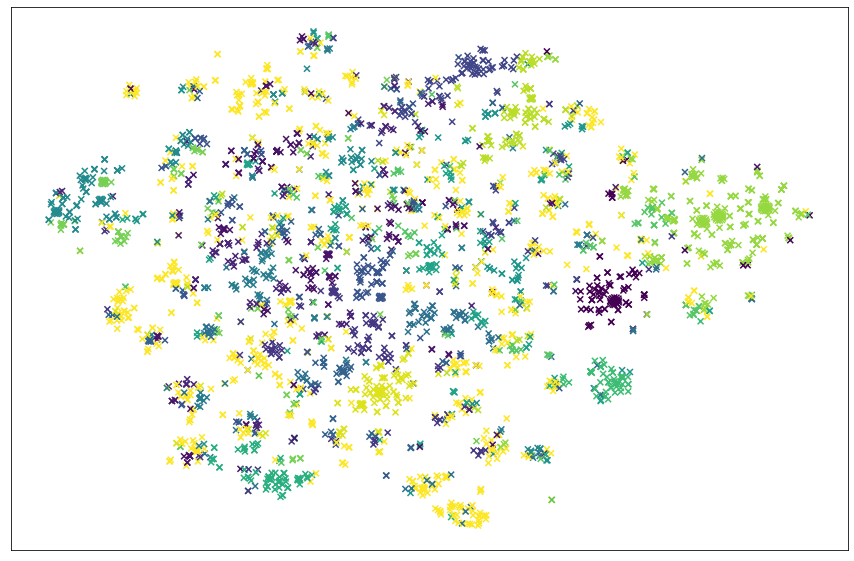

<Figure size 432x288 with 0 Axes>

In [93]:
from sklearn.manifold import TSNE
# 使用T-SNE算法，对权重进行降维，准确度比PCA算法高，但是耗时长
tsne = TSNE(n_components=2)
decomposition_data = tsne.fit_transform(cv_vec)

x = []
y = []

for i in decomposition_data:
    x.append(i[0])
    y.append(i[1])

fig = plt.figure(figsize=(15, 10))
ax = plt.axes()
plt.scatter(x, y, c=kmeans.labels_, marker="x")

plt.xticks(())
plt.yticks(())
plt.show()
plt.savefig('./sample.png', aspect=1)

In [96]:
for i in range(1,n_clusters+1):
    count_word[count_word.words_class == i][['words','lenword_count']].sort_values(by='words').to_csv('./result/class_'+str(i)+'.csv', index=None, columns=['words','lenword_count'])